In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from data.data_handler import SimpleDataset
from models.layers import Reshape
from torch import optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from scipy.stats.mstats import gmean
import torch.distributions as td
from scipy.stats import boxcox

In [2]:
data_dir = "C:/Users/Phili/Documents/exjobb/data/"


In [3]:
# stocks = pd.read_csv(data_dir + "ex.csv").drop_duplicates(["Date", "Isin"])
# stocks = stocks.set_index(["Date", "Isin"]).unstack()

# sector = stocks["Sector"].iloc[-1].dropna()
# ss = sector.unique()
# sec_dict = {ss[i]:i for i in range(len(ss))}
# ctry = stocks["Country"].iloc[-1].dropna()
# closes = stocks["Close"]
# aval_comps = sector.index.intersection(ctry.index)
# closes = closes.reindex(aval_comps, axis=1)
# returns = closes.pct_change().iloc[-122:]#.rolling(5).apply(lambda x: np.prod(1+x)**0.2)[1:].iloc[-61:]
# returns[returns == 0.0] = np.nan
# #returns = closes.iloc[-120:]
# X = []
# t_list = []

# T = 61
# steps = len(returns) // T

# for t in range(steps):
#     df_t = returns.iloc[t*T:(t+1)*T].dropna(axis=1)
#     #df_t = df_t.div(df_t.iloc[0], axis=1)
#     for i in range(df_t.shape[1]):
#         X.append(df_t.iloc[:, i].values)
#         s =sector.iloc[i]
#         t_list.append([sec_dict[s]])
# X = np.array(X)
# t_list = np.array(t_list)

In [4]:
# index = pd.read_csv(data_dir + "index.csv", index_col = 0, parse_dates = True)
# cmdty = pd.read_csv(data_dir + "cmdty_philip.csv", sep=";", decimal=",", index_col = 0, parse_dates = True)
# y = index.join(cmdty).fillna(method="pad").pct_change().dropna()

# X = []
# t_list = []

# T = 5
# steps = len(y) // T
# for t in range(steps):
#     df_t = y.iloc[t*T:(t+1)*T]
#     X.append(df_t.values.reshape(-1,1).squeeze())
#     t_list.append([t])
# X = np.array(X)
# t_list = np.array(t_list)

In [5]:
# stocks = pd.read_csv(data_dir + "philip_data.csv", sep=";", decimal=",").dropna(how="all").fillna(method="pad")
# returns = stocks.pct_change()[1:].iloc[-1200:]
# returns.shape
# X = []
# t_list = []

# T = 61
# steps = len(returns) // T

# for t in range(steps):
#     df_t = returns.iloc[t*T:(t+1)*T].dropna(axis=1, thresh = 55).fillna(0.0)
#     for i in range(df_t.shape[1]):
#         X.append(df_t.iloc[:, i].values)
#         t_list.append([t])
# X = np.array(X)
# t_list = np.array(t_list)

In [67]:
waves = pd.read_csv(data_dir + "ww.csv")
X = waves.iloc[:, :-1].values
t_list = waves.iloc[:, -1].values.reshape(-1,1)
X.shape, t_list.shape


((35065, 366), (35065, 1))

In [68]:
pd.DataFrame(X).dropna().shape, 

((35065, 366),)

In [69]:
# T = 21
# n = 10000
# S = np.zeros((T,n))
# mu = np.zeros(n)
# sigma = np.zeros(n)
# t_list = np.zeros(n)
# mu[:n//3] = 0.025
# sigma[:n//3] = 0.3
# t_list[:n//3] = 0
# mu[n//3:2*n//3] = 0.1
# sigma[n//3:2*n//3] = 0.1
# t_list[n//3:2*n//3] = 1
# mu[2*n//3:] = -0.2
# sigma[2*n//3:] = 0.6
# t_list[2*n//3:] = 2

# dt = 1/252.
# S[0] = 1
# for t in range(T):
#     w = np.random.randn(n)
#     s = mu * dt + np.sqrt(dt)*w*sigma
#     #s = S[t-1] * np.exp((mu - 0.5*sigma**2)*dt + np.sqrt(dt)*w*sigma)
#     S[t] = s

# X = S.T
# t_list = t_list.reshape(-1,1)

In [70]:
# it = pd.read_csv(data_dir + "ItalyPowerDemand_TEST.txt", sep="  ", header=None)
# X = []
# t_list = []
# for i in range(it.shape[0]):
#     it_i = it.iloc[i]
#     X.append(it_i.iloc[1:].values)
#     t_list.append([it_i.iloc[0]])
# X = np.array(X)
# t_list = np.array(t_list)

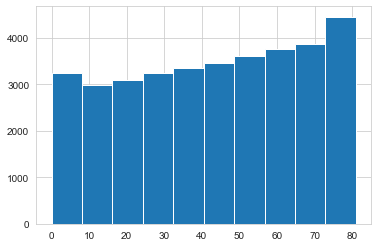

In [71]:
_ = plt.hist(t_list)

In [72]:
X.shape, t_list.shape

((35065, 366), (35065, 1))

In [73]:
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

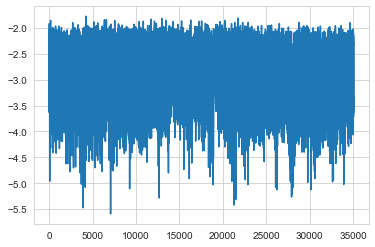

In [74]:
_ = plt.plot(X.min(axis=1))

((35065, 366), (35065, 366))

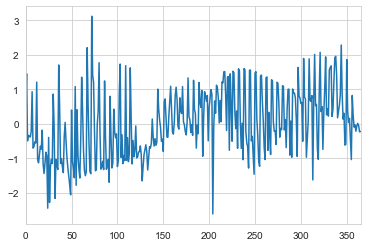

In [75]:
i = np.random.randint(0, len(X))
dd = pd.DataFrame(X)
dd.T.iloc[:,i].plot(legend=False)
# X = pd.DataFrame(X).dropna().values
dd.dropna().shape, dd.shape

In [76]:
data = SimpleDataset(torch.from_numpy(X), torch.from_numpy(t_list))

In [77]:
class Latent(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.mu = nn.Linear(i, o)
        self.log_var = nn.Linear(i, o)
        
        self.elu = nn.ELU()
        
    def _rep(self, mu, log_var):
        eps = torch.randn_like(log_var)
        sigma = torch.exp(0.5 * log_var)
        return mu + eps*sigma
    
    def forward(self, x):
        mu = self.mu(x)
        #mu = self.elu(mu)
        log_var = self.log_var(x)
        #log_var = self.elu(log_var)
        z = self._rep(mu, log_var)
        return z, mu, log_var

class Dense(nn.Module):
    def __init__(self, i,o):
        super().__init__()
        self.l = nn.Sequential(
            nn.Linear(i, o),
            #nn.BatchNorm1d(o),
            nn.ELU()
        )
    def forward(self, x):
        return self.l(x)
    
class Normal(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.mu = nn.Linear(i, o)
        self.log_var = nn.Linear(i,o)
    
    def forward(self, x):
        mu = self.mu(x)
        log_var = self.log_var(x)
        sigma = torch.exp(0.5 * log_var)
        return td.Normal(mu, sigma)
    
class ST(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.df = nn.Sequential(
            nn.Linear(i, o),
            #nn.Softmax()
        )
        self.mu = nn.Linear(i, o)
        self.log_var = nn.Linear(i, o)
    
    def forward(self, x):
        df = self.df(x)
        df = torch.exp(0.5 * df)
        mu = self.mu(x)
        log_var = self.log_var(x)
        sigma = torch.exp(0.5 * log_var)
        return td.StudentT(df, mu, sigma)

In [78]:
class VAE(nn.Module):
    def __init__(self, T, n_z):
        super().__init__()
        
        self.mse = nn.MSELoss(reduction="sum")
        
        self.enc = nn.Sequential(
            Dense(T, 128),
            Dense(128, 64),
            #Dense(64, 64),
            Dense(64, 16),
            Latent(16, n_z)
        )
        self.dec = nn.Sequential(
            Dense(n_z, 16),
            Dense(16, 64),
            #Dense(64, 64),
            Dense(64, 128),
            Dense(128, T)
        )
    
    def encode(self, x):
        return self.enc(x)
    
    def decode(self, z):
        return self.dec(z)
    
    def _dkl(self, mu, log_var):
        alpha = 1.
        vega =1.
        dkl = 0.5 * torch.sum(alpha * mu.pow(2) + log_var.exp() -1 -vega*log_var)
        return dkl
    
    def forward(self, x, beta = 1.0):
        z, mu, log_var = self.enc(x)
        dkl = self._dkl(mu, log_var)
        gen_x = self.dec(z)
        rcl = self.mse(gen_x, x)
        #rcl = -gen_x.log_prob(x).sum()
        loss = rcl + beta*dkl
        return gen_x, loss
    
class CVAE(nn.Module):
    def __init__(self, T, n_z):
        super().__init__()
        
        self.mse = nn.MSELoss(reduction="sum")
        
        self.enc = nn.Sequential(
            Reshape(6, T),
            nn.Conv1d(in_channels = 6, out_channels = 15, kernel_size = 5, stride=1, padding=2),
            #nn.BatchNorm1d(5),
            nn.ELU(),
            
            nn.Conv1d(in_channels = 15, out_channels = 30, kernel_size = 5, stride=2, padding=2),
            #nn.BatchNorm1d(10),
            nn.ELU(),
            
            nn.Flatten(),
            Dense(930, 125),
            Latent(125, n_z)
        )
        self.dec = nn.Sequential(
            Dense(n_z, 125),
            Dense(125, 930),
            Reshape(30, 31),
            
            nn.ConvTranspose1d(in_channels = 30, out_channels = 15, kernel_size=5, stride = 2, padding=2),
            #nn.BatchNorm1d(5),
            nn.ELU(),
            
            nn.ConvTranspose1d(in_channels = 15, out_channels = 6, kernel_size=5, stride=1, padding=2),
            nn.Flatten()
        )
    
    def encode(self, x):
        return self.enc(x)
    
    def decode(self, z):
        return self.dec(z)
    
    def _dkl(self, mu, log_var):
        alpha = 1
        vega = 1
        dkl = 0.5 * torch.sum(alpha * mu.pow(2) + log_var.exp() -1 -vega*log_var)
        return dkl
    
    def forward(self, x, beta = 1.0):
        z, mu, log_var = self.enc(x)
        dkl = self._dkl(mu, log_var)
        gen_x = self.dec(z)
        rcl = self.mse(gen_x, x)
        #rcl = -gen_x.log_prob(x).sum()
        loss = rcl + beta*dkl
        return gen_x, loss
               

In [81]:
n_z = 2

vae = VAE(366, n_z)
opt = optim.Adam(vae.parameters(), lr=1e-3)
sched = optim.lr_scheduler.ReduceLROnPlateau(opt, verbose=True, patience=30)

In [82]:
epochs = 200
losses = []
beta = 0
for e in range(epochs):
    tot_loss = 0
    if e >= 10:
        beta = 0.3
    if e >= 50:
        beta = 3
    for i, (x,t) in enumerate(data.loader):
        opt.zero_grad()
        gen_x, loss = vae(x, beta)
        loss.backward()
        opt.step()
        tot_loss += loss.item()
    if e % 10 == 0:
        print(f"Epoch {e}/{epochs}, Loss: {tot_loss / len(data)}")
    #sched.step(tot_loss)
    losses.append(tot_loss / len(data))

Epoch 0/200, Loss: 232.53292398380685
Epoch 10/200, Loss: 211.90223917300906
Epoch 20/200, Loss: 204.67974272667723
Epoch 30/200, Loss: 202.62263153306804
Epoch 40/200, Loss: 202.03226126367994
Epoch 50/200, Loss: 220.15770122506862
Epoch 60/200, Loss: 218.68970470855464
Epoch 70/200, Loss: 218.8785669248182
Epoch 80/200, Loss: 217.59543611250982
Epoch 90/200, Loss: 216.92822299045076
Epoch 100/200, Loss: 216.96378647801404
Epoch 110/200, Loss: 216.16469689661164
Epoch 120/200, Loss: 218.50737393111453
Epoch 130/200, Loss: 216.1050098087926
Epoch 140/200, Loss: 215.70000252043081
Epoch 150/200, Loss: 215.58748976510142
Epoch 160/200, Loss: 215.7234365948729
Epoch 170/200, Loss: 215.5499334244216
Epoch 180/200, Loss: 217.46645234185618
Epoch 190/200, Loss: 215.9313748379126


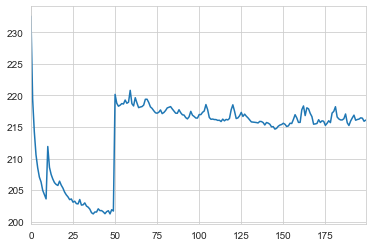

In [83]:
l = pd.Series(losses)
l[l < 1e4].plot()


In [84]:
vae.eval()

VAE(
  (mse): MSELoss()
  (enc): Sequential(
    (0): Dense(
      (l): Sequential(
        (0): Linear(in_features=366, out_features=128, bias=True)
        (1): ELU(alpha=1.0)
      )
    )
    (1): Dense(
      (l): Sequential(
        (0): Linear(in_features=128, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
      )
    )
    (2): Dense(
      (l): Sequential(
        (0): Linear(in_features=64, out_features=16, bias=True)
        (1): ELU(alpha=1.0)
      )
    )
    (3): Latent(
      (mu): Linear(in_features=16, out_features=2, bias=True)
      (log_var): Linear(in_features=16, out_features=2, bias=True)
      (elu): ELU(alpha=1.0)
    )
  )
  (dec): Sequential(
    (0): Dense(
      (l): Sequential(
        (0): Linear(in_features=2, out_features=16, bias=True)
        (1): ELU(alpha=1.0)
      )
    )
    (1): Dense(
      (l): Sequential(
        (0): Linear(in_features=16, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
      )
    )
    (2): Dense(
      (

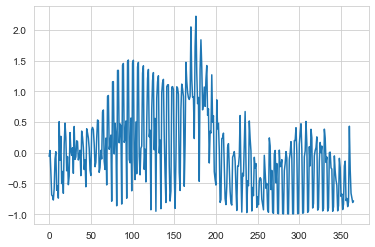

In [85]:
_ = plt.plot(gen_x[0].detach().numpy())

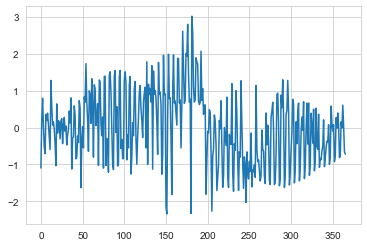

In [86]:
_ = plt.plot(x[0].detach().numpy())

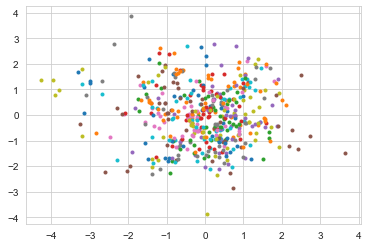

In [87]:
idx = np.random.choice(np.arange(len(data)), 500, replace=False)
X, t = data[idx]
z, mu, log_var = vae.encode(X)
z_df = pd.DataFrame(mu.detach().numpy(), columns=["x","y"])
z_df["label"] = t.detach().numpy()
fig, ax = plt.subplots()
for name, grp in z_df.groupby("label"):
    ax.plot(grp.x, grp.y, marker='o', linestyle='', ms=3, label=name, alpha=1)
#ax.legend()
plt.show()

In [88]:
z.mean(axis=0), z.std(axis=0)

(tensor([-0.0657, -0.0083], grad_fn=<MeanBackward1>),
 tensor([1.1304, 1.1254], grad_fn=<StdBackward1>))

In [89]:
def grad(x, mu):
    return x -mu

def gradm(x, dist):
    mu = dist.mean
    sigma = dist.scale
    return (x - mu) / (sigma**2 + 1e-4)

def gradtt(x, dist):
    mu = dist.mean
    v = dist.df
    sigma = dist.scale
    return (v + 1)*(x - mu) / sigma.pow(2) * (1 + ((x - mu)/sigma)**2 / v)**(-1)

def sgd(x, vae, N=200, alpha = 1, eps=1):
    z_list = []
    g_list = []
    x_list = []
    z, mu, log_var = vae.encode(x)
    z_list.append(mu.unsqueeze(1))
    x_list.append(x.unsqueeze(0))
    for i in range(N):
        a = alpha / np.sqrt(i+1)
        e = eps / np.sqrt(i+1)
        x_z = x + torch.randn_like(x)*np.sqrt(e)
        z, mu, log_var = vae.encode(x_z)
        z_list.append(mu.unsqueeze(1))
        gen_x = vae.decode(z)
        g = grad(x_z, gen_x)
        #g /= g.norm(dim=1, keepdim=True)
        x = x - g*a
        g_list.append(g)
        x_list.append(x.unsqueeze(0))
    return torch.cat(z_list, 1).detach().numpy(), torch.cat(g_list).detach().numpy(), torch.cat(x_list).detach().numpy()

def adam(x, vae, N, alpha):
    z_list = []
    g_list = []
    x_list = []
    beta_1 = 0.9
    beta_2 = 0.999
    eps = 1e-8
    m = 0
    v = 0
    
    z, mu, log_var = vae.encode(x)
    z_list.append(mu.unsqueeze(1))
    x_list.append(x.unsqueeze(0))
    
    
    for i in range(N):
        z, mu, log_var = vae.encode(x)
        gen_x = vae.decode(z)
        g = grad(x, gen_x)
        m = beta_1*m + (1-beta_1)*g
        v = beta_2*v + (1-beta_2)*g.pow(2)
        m_hat = m/(1-beta_1**(i+1))
        v_hat = v/(1-beta_2**(i+1))
        x = x - alpha*m_hat/(torch.sqrt(v_hat)+eps)
        z_list.append(mu.unsqueeze(1))
        g_list.append(g)
        x_list.append(x.unsqueeze(0))
    return torch.cat(z_list, 1).detach().numpy(), torch.cat(g_list).detach().numpy(), torch.cat(x_list).detach().numpy()

In [90]:
x, t = data[:1]
z, g, x = sgd(x, vae, 2000, 0.1, 1)

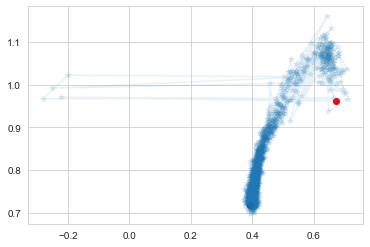

In [91]:
_ = plt.plot(z[0,:,0], z[0,:,1], '*-', alpha=0.1)
_ = plt.scatter(z[0,0,0], z[0,0,1], c="red")
_ = plt.scatter(z[0,-1,0], z[0,-1,1], c="black")

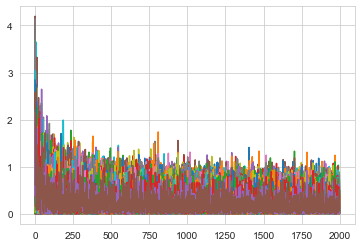

In [92]:
diff = np.abs(np.diff(g, axis=0))
_ = plt.plot(diff)

In [93]:
print(len(data))
with torch.no_grad():
    idx = np.random.choice(np.arange(len(data)), 500, replace=False)
    X, t = data[idx]
    Z, G, x = adam(X, vae, 2000, 0.1)

35065


In [94]:
z_df = pd.DataFrame(Z[:,-1], columns = ["x", "y"])
z_df["label"] = t.detach().numpy()
z_first_df = pd.DataFrame(Z[:,0], columns = ["x", "y"])
z_first_df["label"] = t.detach().numpy()

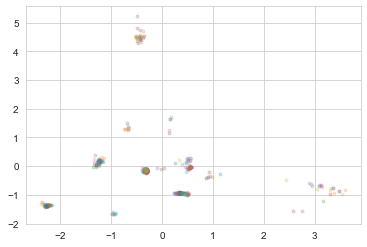

In [95]:
fig, ax = plt.subplots()
for name, grp in z_df.groupby("label"):
    ax.plot(grp.x, grp.y, marker='o', linestyle='', ms=3, label=name, alpha=0.2)
#ax.legend()
plt.show()

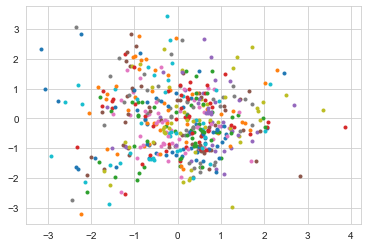

In [96]:
fig, ax = plt.subplots()
for name, grp in z_first_df.groupby("label"):
    ax.plot(grp.x, grp.y, marker='o', linestyle='', ms=3, label=name)
plt.show()

In [97]:
from sklearn.cluster import DBSCAN, KMeans

In [98]:
x.shape
x_df = pd.DataFrame(scaler.inverse_transform(x[0]))
t_df = pd.DataFrame(t.detach().numpy())

(500,)


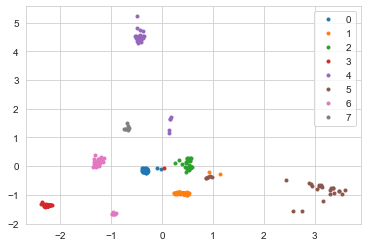

In [99]:
d = KMeans(8)
#d = DBSCAN()
kk = d.fit_predict(x[-1])
print(kk.shape)
z_df["c"] = kk
x_df["c"] = kk
t_df["c"] = kk
fig, ax = plt.subplots()
for name, grp in z_df.groupby("c"):
    ax.plot(grp.x, grp.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()
plt.show()


In [109]:
t_df.columns = ["T", "c"]
def bygrp(grp):
    print(grp)
t_df.groupby("T").apply(bygrp)

       T  c
437  0.0  5
494  0.0  1
       T  c
312  1.0  5
       T  c
90   2.0  0
313  2.0  1
318  2.0  6
382  2.0  1
440  2.0  0
       T  c
20   3.0  0
42   3.0  1
143  3.0  0
246  3.0  1
263  3.0  1
372  3.0  1
       T  c
31   4.0  0
138  4.0  5
177  4.0  5
238  4.0  0
286  4.0  0
       T  c
72   5.0  3
116  5.0  1
122  5.0  1
338  5.0  6
394  5.0  1
467  5.0  0
       T  c
6    6.0  2
98   6.0  1
299  6.0  6
319  6.0  0
324  6.0  1
413  6.0  1
       T  c
146  7.0  1
169  7.0  1
201  7.0  5
       T  c
21   8.0  2
291  8.0  3
395  8.0  1
433  8.0  1
       T  c
29   9.0  3
133  9.0  6
200  9.0  3
264  9.0  1
362  9.0  3
        T  c
50   10.0  6
91   10.0  4
125  10.0  4
        T  c
193  11.0  3
196  11.0  0
197  11.0  6
221  11.0  0
353  11.0  6
464  11.0  0
474  11.0  0
        T  c
265  12.0  0
331  12.0  5
386  12.0  0
485  12.0  6
        T  c
23   13.0  6
262  13.0  5
274  13.0  5
391  13.0  5
430  13.0  6
       T  c
13  14.0  0
       T  c
63  15.0  0
95  15.0  0
     

""


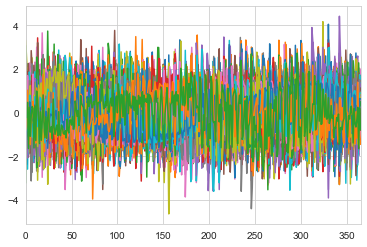

In [101]:
x_df[x_df.c==0].T.drop("c").plot(legend=False)

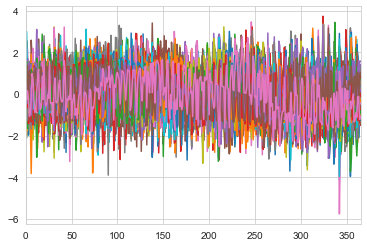

In [102]:
 x_df[x_df.c == 1].T.drop("c").plot(legend=False)

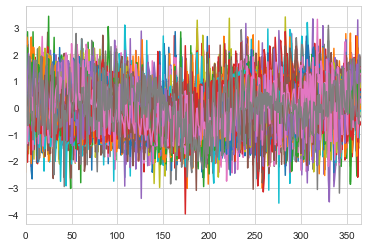

In [103]:
x_df[x_df.c == 2].T.drop("c").plot(legend=False)

In [ ]:
x_df[x_df.c == 3].T.drop("c").plot(legend=False)

In [ ]:
x_df[x_df.c == 4].T.drop("c").plot(legend=False)

In [ ]:
x_df[x_df.c == 5].T.drop("c").plot(legend=False)